In [83]:
library(lme4)
library(tidyr)
library(reshape2)
library(ggplot2)
library(pbkrtest)
library(lmeresampler)

# Simulated data

In [2]:
generate_group_data <- function(categories, mean, group_sd, individual_sd) {
    value <- numeric(length(categories))
    last_category <- category[1]
    group_mean <- rnorm(1, mean=mean, sd=group_sd)
    for (i in 1:length(category)) {
        if (last_category != categories[i]) {
            group_mean <- rnorm(1, mean=mean, sd=group_sd)
            last_category <- categories[i]
        }
        value[i] <- rnorm(1, mean=group_mean, sd=individual_sd)
    }
    return(value)
}

In [56]:
LETTERS

[1] "A" "B" "C" "D" "E" "F" "G" "H" "I" "J" "K" "L" "M" "N" "O" "P" "Q" "R" "S"
[20] "T" "U" "V" "W" "X" "Y" "Z"

In [3]:
NPERGROUP <- 10

category <- rep('A', NPERGROUP)
for (cat in LETTERS[2:5]) {
    category <- c(category, rep(cat, NPERGROUP))
}

In [35]:
method <- vector(mode='character')
means <- numeric(8000)

for (i in 1:length(means) / 2) {
    value <- generate_group_data(category, 5, 5, 1)
    means[i] <- sd(apply(matrix(value, ncol=NPERGROUP), 1, mean)) / sqrt(5)
    method[i] <- 'g'
    means[i + length(means) / 2] <- sd(value) / sqrt(NPERGROUP * 5)
    method[i + length(means) / 2] <- 'a'
}

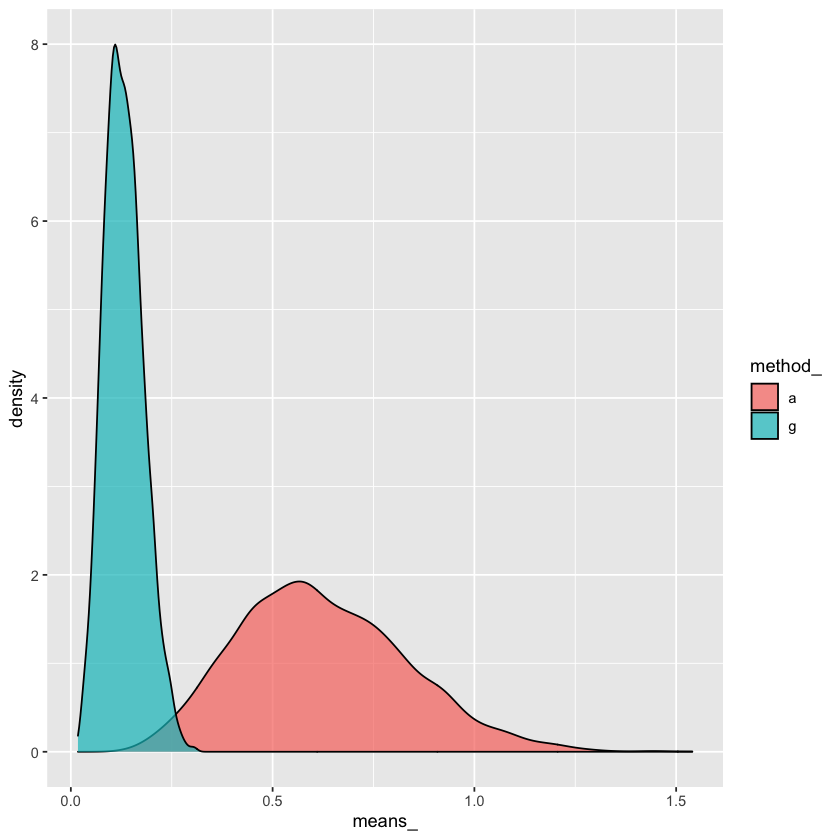

In [36]:
ggplot(data.frame(method_=as.factor(method), means_=means), aes(x=means_, fill=method_)) + geom_density(alpha=0.7)

In [34]:
describe(data.frame(method_=as.factor(method), means_=means))

ERROR: Error in describe(data.frame(method_ = as.factor(method), means_ = means)): could not find function "describe"


In [75]:
toy.me.mod <- lmer(value ~ 1 + (1 | category))
toy.lin.mod <- lm(value ~ category)
toy.int.mod <- lm(value ~ 1)

In [76]:
summary(toy.me.mod)

Linear mixed model fit by REML ['lmerMod']
Formula: value ~ 1 + (1 | category)

REML criterion at convergence: 2391

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.91865 -0.69709  0.03135  0.62807  3.09357 

Random effects:
 Groups   Name        Variance Std.Dev.
 category (Intercept) 0.2696   0.5192  
 Residual             1.0403   1.0200  
Number of obs: 810, groups:  category, 27

Fixed effects:
            Estimate Std. Error t value
(Intercept)   4.9884     0.1062   46.99

In [45]:
0.2004/sqrt(6)

[1] 0.08181296

In [47]:
sqrt(0.04017 / 6 + 0.98010 / 180)

[1] 0.1101817

In [43]:
sqrt(0.7**2/369 + 1.3**2/83)

[1] 0.1472731

In [37]:
summary(toy.int.mod)


Call:
lm(formula = value ~ 1)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.80535 -0.29204  0.01121  0.79241  1.25194 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.07890    0.06027   84.27   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8086 on 179 degrees of freedom


# Real data

In [2]:
similarity = read.csv('../../interneuron-reward-data/processed/ideal_projection_similarity.csv')

In [3]:
head(similarity)

day,cell_type,cell_id,mouse_id,tone,tone...delay,delay,reward
1,vip,3121,CL136,0.15632806,-0.01679954,-0.149223649,-0.164519399
7,vip,3121,CL136,-0.12633433,-0.04920072,0.042998157,-0.267080236
1,vip,3122,CL136,0.31542185,0.18786636,-0.026980097,-0.463461517
7,vip,3122,CL136,-0.16400974,-0.36465279,-0.315953990,-0.044661023
1,vip,3123,CL136,0.12464616,0.07663999,-0.007694931,-0.006051957
7,vip,3123,CL136,0.03489094,0.03259205,0.011614262,-0.065886500


In [4]:
day7_similarity <- similarity[similarity['day'] == 7, ]

In [30]:
reward.mermod <- lmer(reward ~ 1 + cell_type + (1 | mouse_id), data=day7_similarity, REML=FALSE)
summary(reward.mermod)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: reward ~ 1 + cell_type + (1 | mouse_id)
   Data: day7_similarity

     AIC      BIC   logLik deviance df.resid 
   -14.7     13.3     12.3    -24.7     1996 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.0958 -0.6513 -0.1370  0.4860  4.0840 

Random effects:
 Groups   Name        Variance Std.Dev.
 mouse_id (Intercept) 0.01413  0.1189  
 Residual             0.05628  0.2372  
Number of obs: 2001, groups:  mouse_id, 17

Fixed effects:
             Estimate Std. Error t value
(Intercept)   0.07853    0.05087   1.544
cell_typepyr -0.14803    0.07071  -2.093
cell_typevip  0.05292    0.07442   0.711

Correlation of Fixed Effects:
            (Intr) cll_typp
cell_typpyr -0.719         
cell_typevp -0.684  0.492  

In [31]:
reward.mermod.restricted <- lmer(reward ~ 1 + (1 | mouse_id), data=day7_similarity, REML=FALSE)
bs.results <- PBmodcomp(reward.mermod, reward.mermod.restricted, nsim=5000, details=1)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00287105 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00308977 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00627741 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00573679 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00255446 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00215112 (tol = 0.002, compo

“Model failed to converge with max|grad| = 0.00434151 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00284178 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.0032902 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00289075 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00382782 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00345595 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkC

“Model failed to converge with max|grad| = 0.00276396 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00276421 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00307561 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00337644 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00327603 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00317367 (tol = 0.002, component 1)”

Reference distribution with  5000 samples; computing time: 108.32 secs. 


In [32]:
summary(bs.results)

Parametric bootstrap test; time: 108.32 sec; samples: 5000 extremes: 324;
large : reward ~ 1 + cell_type + (1 | mouse_id)
small : reward ~ 1 + (1 | mouse_id)
           stat     df   ddf p.value  
PBtest   6.7853              0.06499 .
Gamma    6.7853              0.06321 .
Bartlett 5.5454 2.0000       0.06249 .
F        3.3926 2.0000 3.382 0.15547  
LRT      6.7853 2.0000       0.03362 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


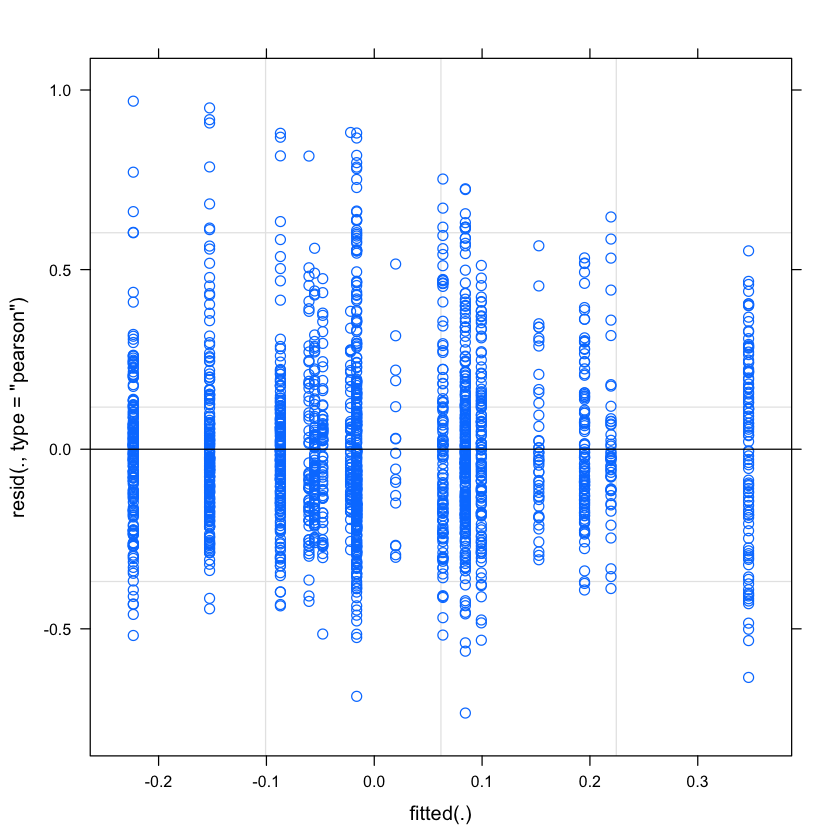

In [39]:
plot(reward.mermod)

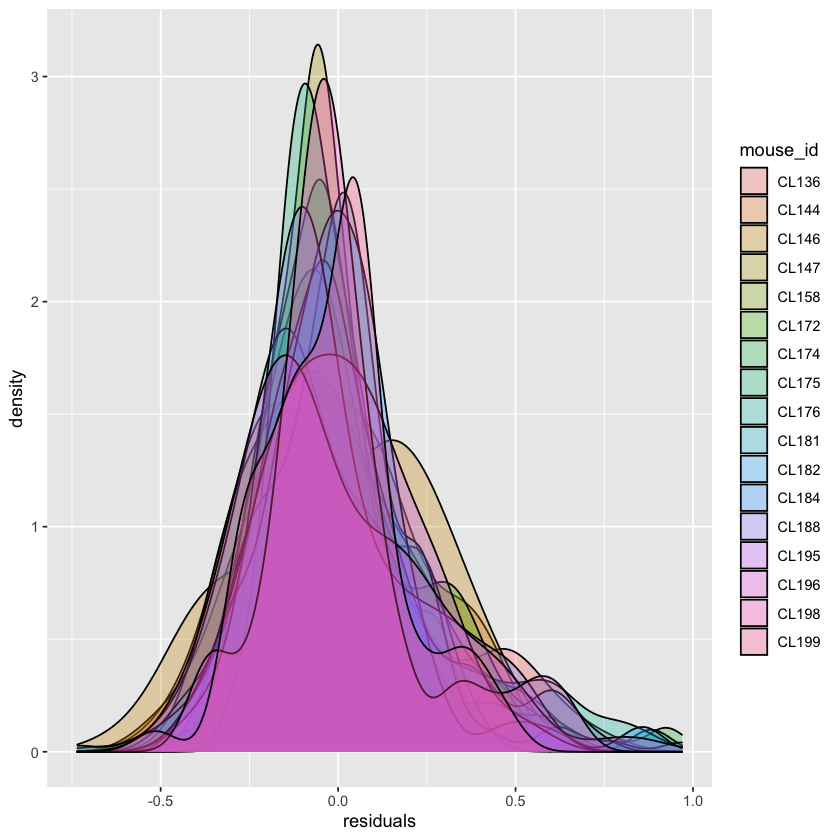

In [47]:
ggplot(
    data.frame(residuals=resid(reward.mermod), mouse_id=day7_similarity['mouse_id']),
    aes(x=residuals, fill=mouse_id)
) + geom_density(alpha=0.3)

In [52]:
bootstrap(reward.mermod)

NULL

In [86]:
sample(c(1, 2, 3), 3, replace=TRUE) + c(1, 2, 3)

[1] 3 4 5

In [128]:
bootstrap_day7 <- function(response_variable, n_iter) {
    restricted.formula <- paste0(response_variable, '~ 1 + (1 | mouse_id)')
    full.formula <- paste0(response_variable, '~ 1 + cell_type + (1 | mouse_id)')
    
    mermod.restricted <- lmer(restricted.formula, data=day7_similarity, REML=FALSE)
    teststat.bs <- numeric(n_iter)
    for (i in 1:n_iter) {
        data.bs <- day7_similarity
        data.bs[response_variable] <- (
            fitted(mermod.restricted)
            + sample(resid(mermod.restricted), length(resid(mermod.restricted)), replace=TRUE)
        )
        
        # Re-fit the restricted model using data bootstrapped from itself
        mermod.restricted.bs <- lmer(paste0(response_variable, '~ 1 + (1 | mouse_id)'), data=data.bs, REML=FALSE)
        
        # Re-fit full model using data bootstrapped from small model -- shouldn't produce any improvement
        mermod.bs <- lmer(full.formula, data=data.bs, REML=FALSE)
        
        # Get LR test statistic under null hypothesis
        teststat.bs[i] <- getLRT(mermod.bs, mermod.restricted.bs)[['tobs']]
    }
    
    mermod.full <- lmer(full.formula, data=day7_similarity, REML=FALSE)
    teststat <- getLRT(mermod.full, mermod.restricted)[['tobs']]
    
    return(sum(teststat < teststat.bs) / n_iter)
}

In [129]:
bootstrap_day7('reward', 500)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00288921 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00290366 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00295104 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00297152 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00288917 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00285335 (tol = 0.002, compo

[1] 0.47

In [130]:
bootstrap_day7('tone...delay', 500)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00584941 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00322464 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00248699 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00315857 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00309425 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00302946 (tol = 0.002, compo

[1] 0.588

In [131]:
bootstrap_day7('tone', 500)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.0037317 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00393409 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.0024057 (tol = 0.002, component 1)”

[1] 0.374

In [132]:
bootstrap_day7('delay', 500)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00265517 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00412785 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00372818 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00394104 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00267394 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00415419 (tol = 0.002, compo

[1] 0.336

In [193]:
bootstrap_difference <- function(response_variable, n_iter) {
    difference_data <- (
        similarity[, c('day', 'cell_id', 'cell_type', 'mouse_id', response_variable)] 
        %>% spread(day, response_variable)
    )
    difference_data['learning'] <- difference_data['7'] - difference_data['1']
    difference_data <- difference_data[complete.cases(difference_data), ]
    
    restricted.formula <- 'learning ~ 1 + (1 | mouse_id)'
    full.formula <- 'learning ~ 1 + cell_type + (1 | mouse_id)'
    
    mermod.restricted <- lmer(restricted.formula, data=difference_data, REML=FALSE)
    mermod.full <- lmer(full.formula, data=difference_data, REML=FALSE)
    teststat.bs <- numeric(n_iter)
    for (i in 1:n_iter) {
        data.bs <- difference_data
        data.bs['learning'] <- (
            fitted(mermod.restricted)
            + sample(resid(mermod.restricted), length(resid(mermod.restricted)), replace=TRUE)
        )
        
        # Re-fit the restricted model using data bootstrapped from itself
        mermod.restricted.bs <- lmer(restricted.formula, data=data.bs, REML=FALSE)
        
        # Re-fit full model using data bootstrapped from small model -- shouldn't produce any improvement
        mermod.bs <- lmer(full.formula, data=data.bs, REML=FALSE)
        
        # Get LR test statistic under null hypothesis
        teststat.bs[i] <- getLRT(mermod.bs, mermod.restricted.bs)[['tobs']]
    }
    
    teststat <- getLRT(mermod.full, mermod.restricted)[['tobs']]
    
    return(sum(teststat < teststat.bs) / n_iter)
}

In [194]:
bootstrap_difference('reward', 500)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00281794 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00294812 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00228988 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00337381 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00293181 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00298764 (tol = 0.002, compo

[1] 0.488

In [186]:
bootstrap_difference('tone...delay', 500)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00256954 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00269685 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00273017 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00255458 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00270768 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00267231 (tol = 0.002, compo

[1] 0.432

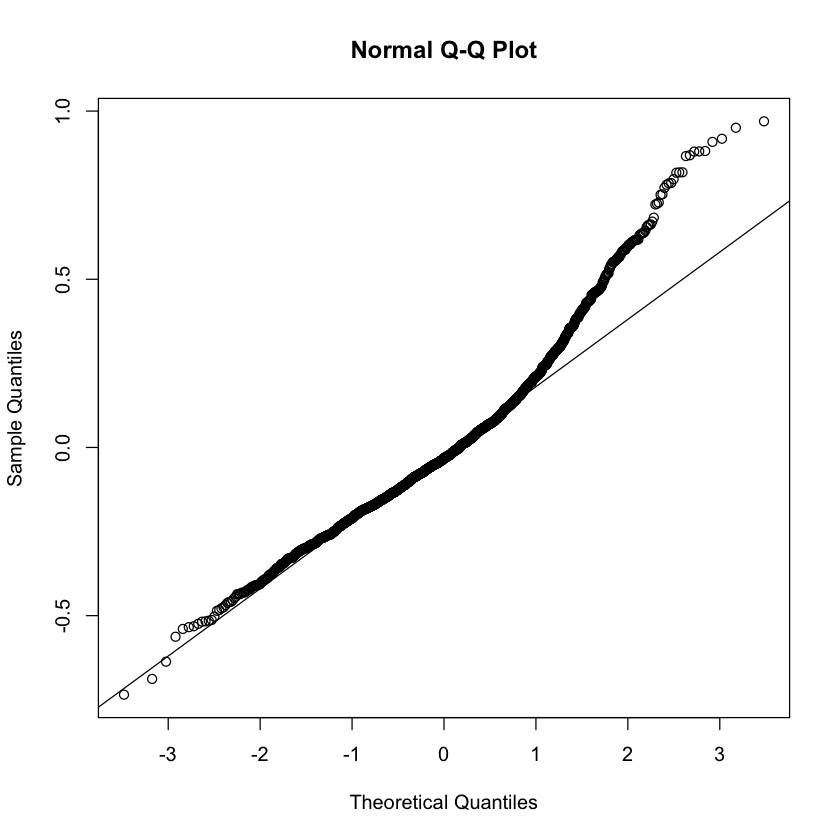

In [19]:
qqnorm(resid(reward.mermod))
qqline(resid(reward.mermod))

In [36]:
reward.mod <- lm(reward ~ 1 + cell_type, data=day7_similarity)
reward.mod.restricted <- lm(reward ~ 1, data=day7_similarity)
summary(reward.mod)


Call:
lm(formula = reward ~ 1 + cell_type, data = day7_similarity)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.69536 -0.17399 -0.03948  0.13609  0.92546 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.05125    0.01494   3.431 0.000613 ***
cell_typepyr -0.11276    0.01676  -6.729 2.23e-11 ***
cell_typevip  0.08184    0.01917   4.269 2.06e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2638 on 1998 degrees of freedom
Multiple R-squared:  0.09089,	Adjusted R-squared:  0.08998 
F-statistic: 99.88 on 2 and 1998 DF,  p-value: < 2.2e-16


In [37]:
summary(PBmodcomp(reward.mod, reward.mod.restricted))

Parametric bootstrap test; time: 1.48 sec; samples: 1000 extremes: 0;
large : reward ~ 1 + cell_type
small : reward ~ 1
            stat      df    ddf   p.value    
PBtest   190.677                0.0009990 ***
Gamma    190.677                < 2.2e-16 ***
Bartlett 181.889   2.000        < 2.2e-16 ***
F         95.338   2.000 3.8238 0.0005464 ***
LRT      190.677   2.000        < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


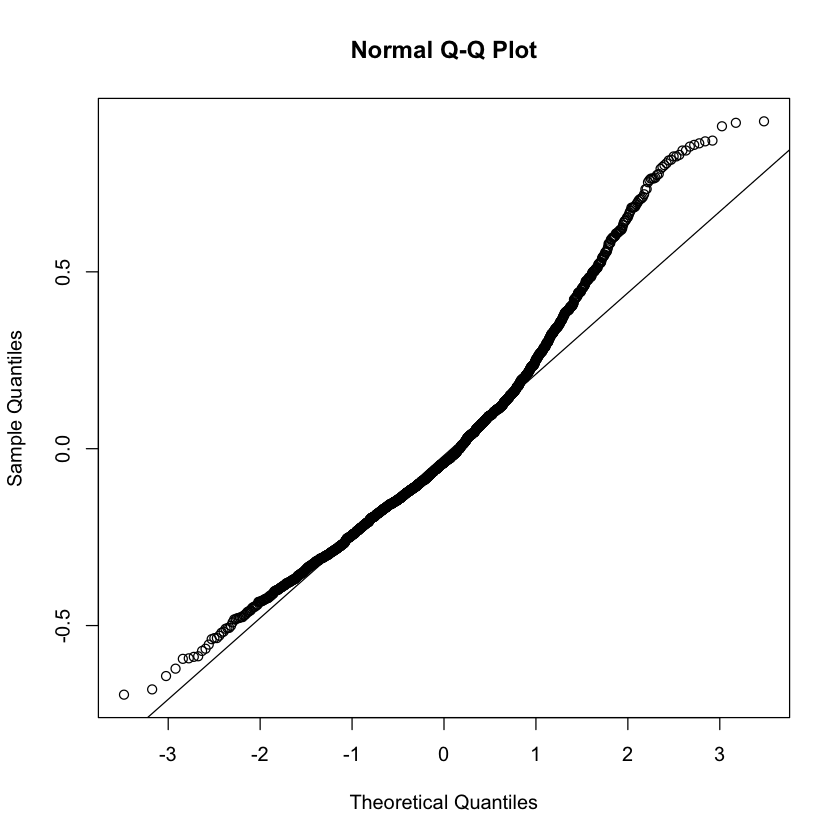

In [18]:
qqnorm(resid(reward.mod))
qqline(resid(reward.mod))

In [15]:
vip_rew_tmp <- similarity[
    similarity['cell_type'] == 'vip', 
    c('day', 'cell_id', 'mouse_id', 'reward')
] %>% spread(day, reward)
vip_reward <- vip_rew_tmp
vip_reward['reward_learning'] <- vip_reward['7'] - vip_reward['1']
#vip_reward <- subset(vip_reward, select=-c('1', '7'))
rm(vip_rew_tmp)

head(vip_reward)

cell_id,mouse_id,1,7,reward_learning
2894,CL144,-0.22633541,0.51031111,0.73664653
2895,CL144,0.24146387,-0.01854660,-0.26001047
2896,CL144,-0.02387209,0.09772653,0.12159862
2897,CL144,0.50945273,0.01041427,-0.49903846
2898,CL144,0.13104005,0.08040750,-0.05063255
2899,CL144,-0.04082985,0.30959373,0.35042358


In [18]:
vip.reward.mod <- lmer(
    reward_learning ~ 1 + (1 | mouse_id), data=vip_reward
)
summary(vip.reward.mod)

Linear mixed model fit by REML ['lmerMod']
Formula: reward_learning ~ 1 + (1 | mouse_id)
   Data: vip_reward

REML criterion at convergence: 334.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1180 -0.6431 -0.0880  0.6193  3.5596 

Random effects:
 Groups   Name        Variance Std.Dev.
 mouse_id (Intercept) 0.05909  0.2431  
 Residual             0.11215  0.3349  
Number of obs: 482, groups:  mouse_id, 5

Fixed effects:
            Estimate Std. Error t value
(Intercept)   0.1902     0.1098   1.731

In [45]:
rew_tmp <- similarity[
    similarity['cell_type'] == 'pyr', 
    c('day', 'cell_id', 'mouse_id', 'reward')
] %>% spread(day, reward)
pyr_reward <- rew_tmp
pyr_reward['reward_learning'] <- pyr_reward['7'] - pyr_reward['1']
#vip_reward <- subset(vip_reward, select=-c('1', '7'))
rm(rew_tmp)

head(pyr_reward)

cell_id,mouse_id,1,7,reward_learning
1,CL174,0.43473304,0.46288298,0.02814994
2,CL174,-0.10080116,0.16236920,0.26317036
3,CL174,0.24577416,-0.17442694,-0.42020110
4,CL174,-0.09054792,-0.39903313,-0.30848521
5,CL174,-0.66225343,-0.01079882,0.65145461
6,CL174,-0.47028667,0.04703573,0.51732240


In [76]:
xtabs(~ cell_id + mouse_id, similarity[
        similarity['cell_type'] == 'pyr', 
        c('day', 'cell_id', 'mouse_id', 'reward')
    ], sparse=T, drop=T)

1207 x 6 sparse Matrix of class "dgCMatrix"
       mouse_id
cell_id CL174 CL175 CL176 CL181 CL182 CL184
   1        2     .     .     .     .     .
   2        2     .     .     .     .     .
   3        2     .     .     .     .     .
   4        2     .     .     .     .     .
   5        2     .     .     .     .     .
   6        2     .     .     .     .     .
   7        2     .     .     .     .     .
   8        2     .     .     .     .     .
   9        2     .     .     .     .     .
   10       2     .     .     .     .     .
   11       2     .     .     .     .     .
   12       2     .     .     .     .     .
   13       2     .     .     .     .     .
   14       2     .     .     .     .     .
   15       2     .     .     .     .     .
   16       2     .     .     .     .     .
   17       2     .     .     .     .     .
   18       2     .     .     .     .     .
   19       2     .     .     .     .     .
   20       2     .     .     .     .     .
   21       2   

In [136]:
simple.mod <- lm(
    reward ~ 1 + day + cell_id,
    data=similarity[
        similarity['cell_type'] == 'pyr', 
        c('day', 'cell_id', 'mouse_id', 'reward')
    ]
)
summary(simple.mod)


Call:
lm(formula = reward ~ 1 + day + cell_id, data = similarity[similarity["cell_type"] == 
    "pyr", c("day", "cell_id", "mouse_id", "reward")])

Residuals:
    Min      1Q  Median      3Q     Max 
-0.6428 -0.1300  0.0000  0.1300  0.6428 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.517423   0.197578   2.619 0.008934 ** 
day         -0.017154   0.001894  -9.055  < 2e-16 ***
cell_id2    -0.418024   0.279212  -1.497 0.134615    
cell_id3    -0.413134   0.279212  -1.480 0.139230    
cell_id4    -0.693599   0.279212  -2.484 0.013122 *  
cell_id5    -0.785334   0.279212  -2.813 0.004993 ** 
cell_id6    -0.660433   0.279212  -2.365 0.018171 *  
cell_id7    -0.504975   0.279212  -1.809 0.070767 .  
cell_id8    -0.418436   0.279212  -1.499 0.134232    
cell_id9    -0.253792   0.279212  -0.909 0.363554    
cell_id10    0.113143   0.279212   0.405 0.685385    
cell_id11   -0.392870   0.279212  -1.407 0.159666    
cell_id12   -0.334447   0.279212  -1.198

In [137]:
pyr.reward.mod <- lmer(
    reward ~ 1 + day + cell_id + (1 | mouse_id),
    data=similarity[
        similarity['cell_type'] == 'pyr', 
        c('day', 'cell_id', 'mouse_id', 'reward')
    ]
)
summary(pyr.reward.mod)


Correlation matrix not shown by default, as p = 1208 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Linear mixed model fit by REML ['lmerMod']
Formula: reward ~ 1 + day + cell_id + (1 | mouse_id)
   Data: similarity[similarity["cell_type"] == "pyr", c("day", "cell_id",  
    "mouse_id", "reward")]

REML criterion at convergence: 1191.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.3022 -0.4655  0.0000  0.4655  2.3022 

Random effects:
 Groups   Name        Variance Std.Dev.
 mouse_id (Intercept) 0.00215  0.04637 
 Residual             0.07796  0.27921 
Number of obs: 2414, groups:  mouse_id, 6

Fixed effects:
             Estimate Std. Error t value
(Intercept)  0.517423   0.202947   2.550
day         -0.017154   0.001894  -9.055
cell_id2    -0.418024   0.279212  -1.497
cell_id3    -0.413134   0.279212  -1.480
cell_id4    -0.693599   0.279212  -2.484
cell_id5    -0.785334   0.279212  -2.813
cell_id6    -0.660433   0.279212  -2.365
cell_id7    -0.504975   0.279212  -1.809
cell_id8    -0.418436   0.279212  -1.499
cell_id9    -0.253792   0.279212  -0.909
cell_id10    0

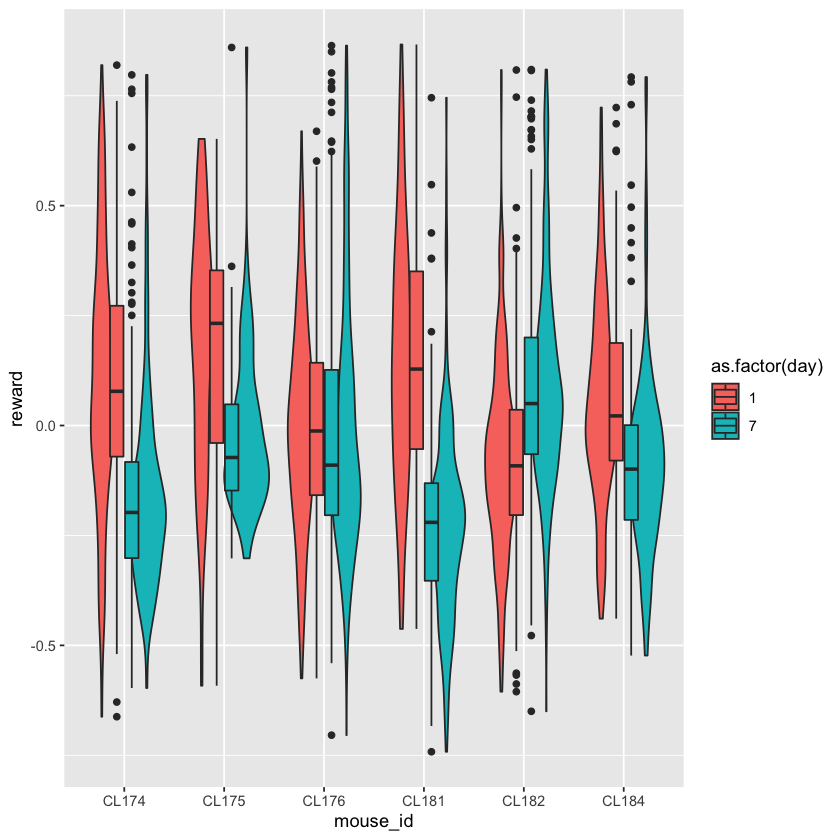

In [133]:
ggplot(similarity[
        similarity['cell_type'] == 'pyr', 
        c('day', 'cell_id', 'mouse_id', 'reward')
    ], aes(x=mouse_id, y=reward, fill=as.factor(day))) + geom_violin() + geom_boxplot(width=0.3)

In [105]:
ggplot(melt(getME(pyr.reward.mod, "Z")), aes(Var1, Var2, fill=value)) + geom_raster()

ERROR: Error in as.data.frame.default(x[[i]], optional = TRUE): cannot coerce class ‘structure("dgCMatrix", package = "Matrix")’ to a data.frame


In [107]:
as.data.frame(getME(pyr.reward.mod, "Z"))

ERROR: Error in as.data.frame.default(getME(pyr.reward.mod, "Z")): cannot coerce class ‘structure("dgCMatrix", package = "Matrix")’ to a data.frame


In [81]:
qqplot(fixef(pyr.reward.mod)[1])

ERROR: Error in sort(y): argument "y" is missing, with no default


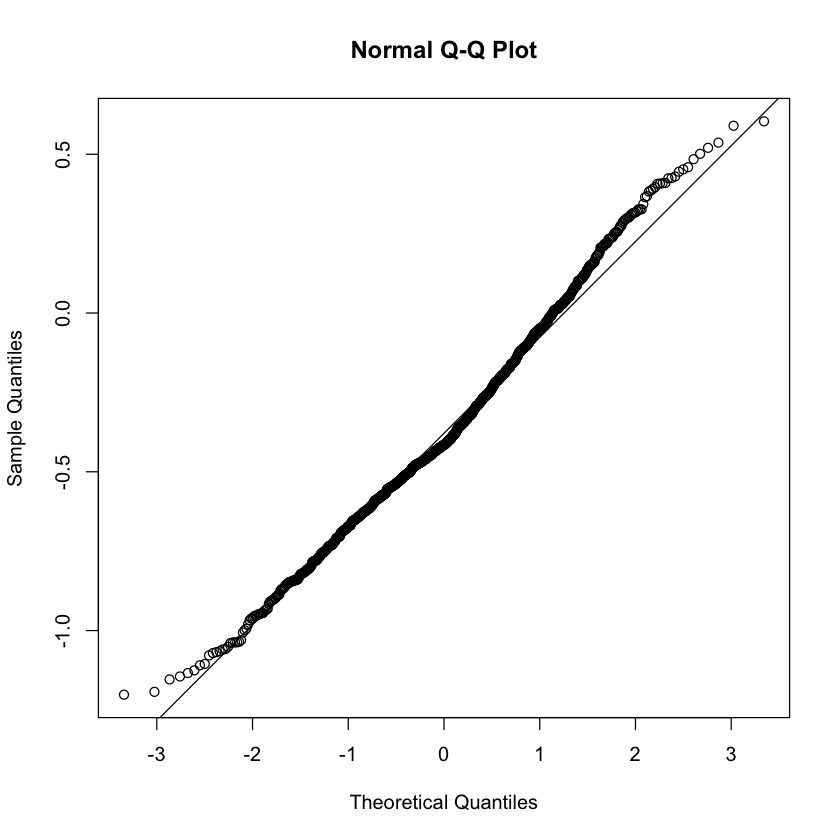

In [93]:
qqnorm(as.vector(fixef(pyr.reward.mod)[3:1206]))
qqline(as.vector(fixef(pyr.reward.mod)[3:1206]))

In [62]:
pyr.reward.mod <- lmer(
    reward_learning ~ 1 + (1 | mouse_id), data=pyr_reward
)
ranef(pyr.reward.mod)

$mouse_id
       (Intercept)
CL174 -0.119766831
CL175 -0.050103523
CL176  0.120309223
CL181 -0.239249790
CL182  0.293572866
CL184 -0.004761943

with conditional variances for “mouse_id” 

In [53]:
ranef(pyr.reward.mod)

$mouse_id
      (Intercept)
CL174 -0.25238684
CL175 -0.17983599
CL176 -0.01196991
CL181 -0.37224356
CL182  0.16212097
CL184 -0.13671047

with conditional variances for “mouse_id” 

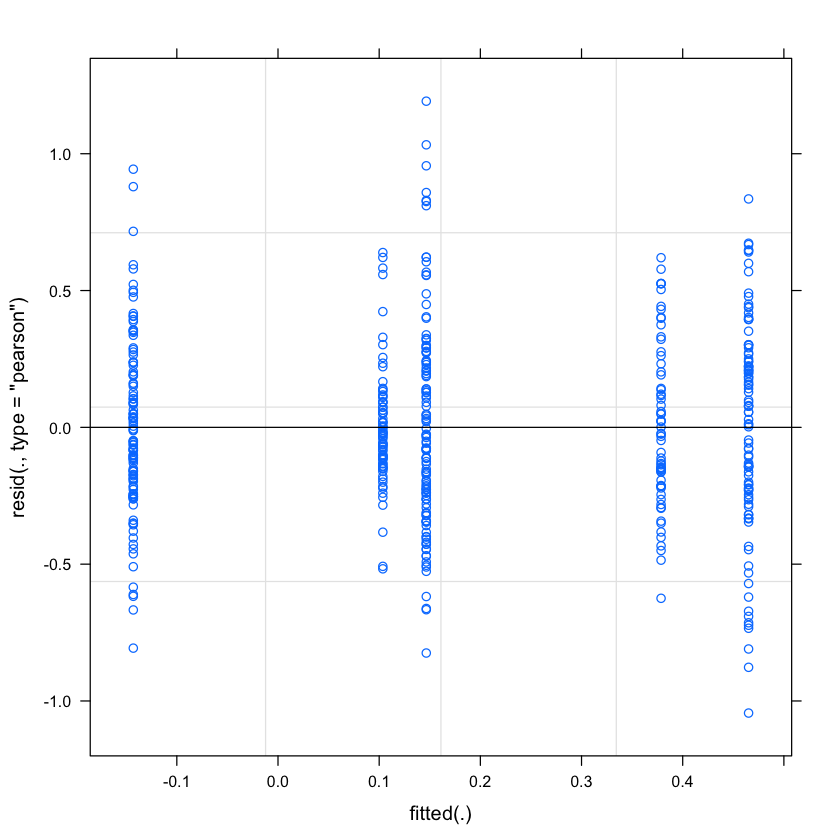

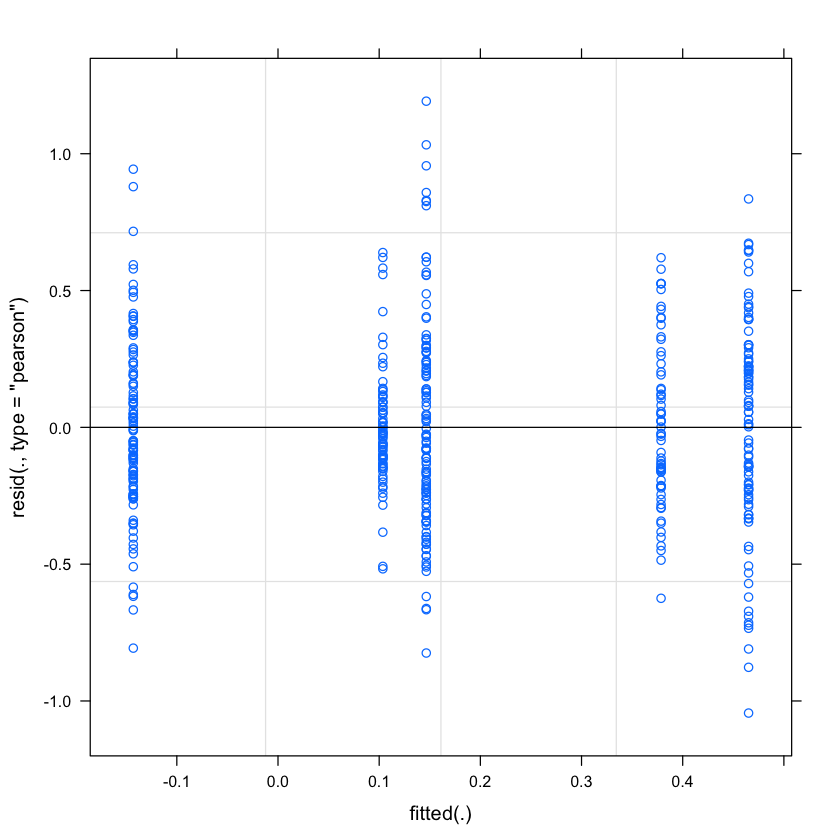

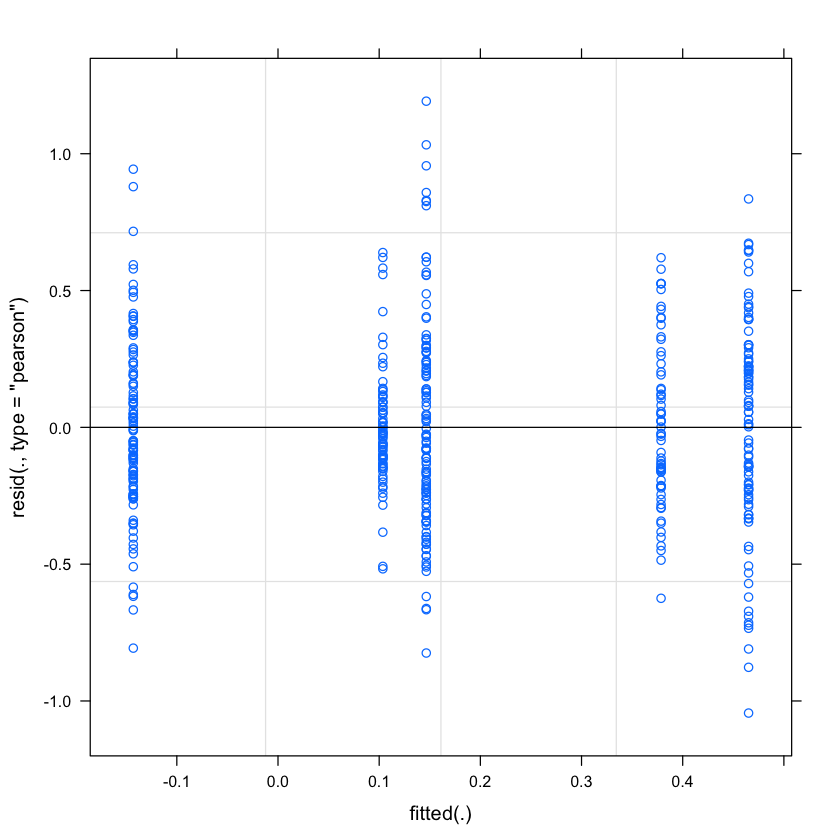

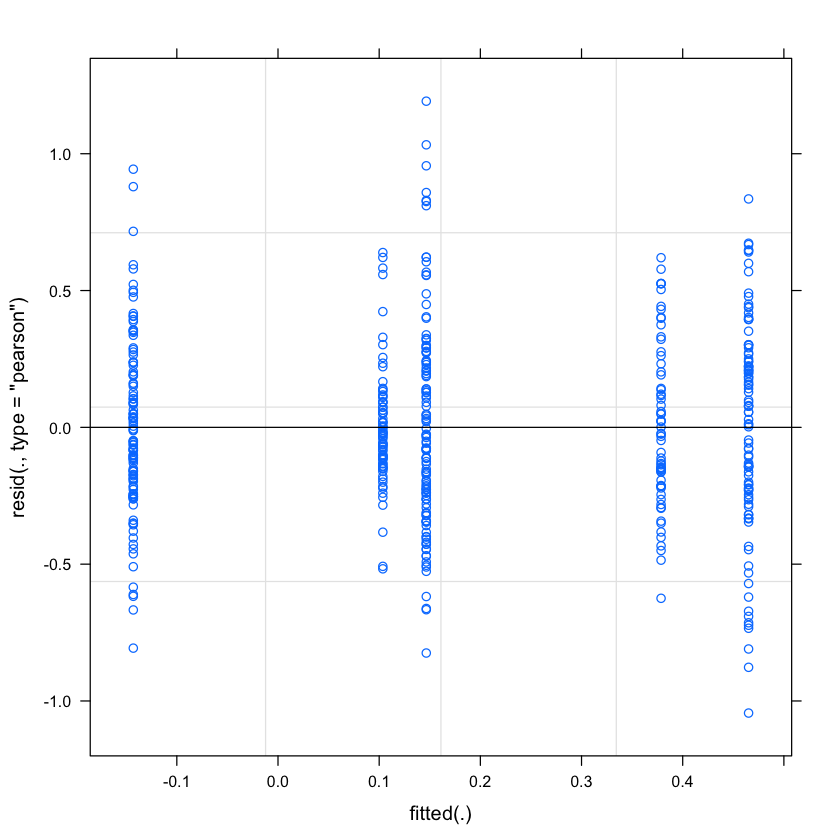

In [25]:
par(mfrow=c(2, 2))
plot(reward.mod)

In [44]:
reward.mod <- lmer(
    reward ~ 1 + day + cell_type + day:cell_type + (0 + day | cell_id), 
    data=similarity
)
summary(reward.mod)

boundary (singular) fit: see ?isSingular


Linear mixed model fit by REML ['lmerMod']
Formula: reward ~ 1 + day + cell_type + day:cell_type + (0 + day | cell_id)
   Data: similarity

REML criterion at convergence: 703.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.6793 -0.6621 -0.1178  0.5599  3.5238 

Random effects:
 Groups   Name Variance  Std.Dev. 
 cell_id  day  2.765e-16 1.663e-08
 Residual      6.897e-02 2.626e-01
Number of obs: 4003, groups:  cell_id, 2002

Fixed effects:
                  Estimate Std. Error t value
(Intercept)       0.062171   0.017523   3.548
day              -0.001560   0.003505  -0.445
cell_typepyr     -0.003600   0.019657  -0.183
cell_typevip     -0.124398   0.022481  -5.533
day:cell_typepyr -0.015594   0.003931  -3.966
day:cell_typevip  0.029463   0.004497   6.552

Correlation of Fixed Effects:
            (Intr) day    cll_typp cll_typv dy:cll_typp
day         -0.800                                     
cell_typpyr -0.891  0.713                              
cell_typevp -0.779

In [39]:
reward.mod <- lm(
    reward ~ 1 + day:cell_id + day:cell_type + day:mouse_id,
    data=similarity
)
summary(reward.mod)


Call:
lm(formula = reward ~ 1 + day:cell_id + day:cell_type + day:mouse_id, 
    data = similarity)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.76940 -0.05541  0.00000  0.04674  0.85380 

Coefficients: (18 not defined because of singularities)
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        2.980e-02  7.026e-03   4.241 2.33e-05 ***
day:cell_id1       6.873e-02  3.773e-02   1.821  0.06869 .  
day:cell_id2       1.595e-02  3.773e-02   0.423  0.67260    
day:cell_id3      -2.427e-02  3.773e-02  -0.643  0.52014    
day:cell_id4      -6.244e-02  3.773e-02  -1.655  0.09812 .  
day:cell_id5      -1.952e-02  3.773e-02  -0.517  0.60492    
day:cell_id6      -7.588e-03  3.773e-02  -0.201  0.84064    
day:cell_id7      -4.000e-02  3.773e-02  -1.060  0.28927    
day:cell_id8      -7.170e-02  3.773e-02  -1.900  0.05756 .  
day:cell_id9       4.207e-02  3.773e-02   1.115  0.26500    
day:cell_id10      6.725e-02  3.773e-02   1.782  0.07485 .  
day:ce

In [38]:
similarity$cell_id <- as.factor(similarity$cell_id)